In [2]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
from patsy import dmatrix
from py12box_invert.paths import Paths
from py12box_invert.invert import Invert
from py12box_invert.plot import plot_mf, plot_emissions
from py12box import core

Use a set of knots and splines to estimate emissions over time.
I just drop any hear with any NaN obs for now. May have to split the H matrix into multiple matrices for it to work.
Just do a standard Normal inversion with MCMC

In [3]:
species = "CFC-11"
project_path = Paths.data / f"example/{species}"

In [28]:
# Just run to get matrices
inv_true = Invert(project_path, species, method="analytical_gaussian", n_threads=4, sensitivity_freq="yearly", start_year=2000, end_year=2020)
# Is hard to deal with years with only some data, so for now just drop any year that has some missing 
inv_true.obs.mf[np.isnan(np.sum(inv_true.obs.mf, axis=1)), :] = np.nan
inv_true.run_inversion([70., 20., 10., 10.])

Setting up inversion for CFC-11

No units given for emissions. Assuming Gg/yr
No inital conditions file 
... assuming zero initial conditions
Compiling model and tuning lifetime...
... completed in 3 iterations
... stratospheric lifetime: 55.0
... OH lifetime: 1e12
... ocean lifetime: 1e12
... non-OH tropospheric lifetime: 1e12
... overall lifetime: 55.05
... done in 0.0007 s
Calculating flux sensitivity on 4 threads...


/user/home/lw13938/work/py12box_invert/py12box_invert/invert.py:117: UserWarning: Can't have both a start_year and ic_years
 Setting ic_years to None.
  warnings.warn("Can't have both a start_year and ic_years\n Setting ic_years to None.")


... done
Spinning up for 9 years and estimating initial conditions...
... done
Run inversion...
... done
Calculating outputs...
... calculating posterior ensembles
... done



In [65]:
# Get all years where we have data
# Note, there's no data in 2020 so the times in the H matrix are only until 2019
time = np.arange(2000,2020)

In [68]:
# Start by just having 11 evenly spaced knots over the 20 years
knot_list = np.linspace(2000,2020, 10)

B_i = dmatrix(
    "bs(time, knots=knots, degree=3, include_intercept=False) - 1",
    {"time": time, "knots": knot_list[1:-1]},
)

# As we have 4 boxes, we're going to have to repeat it
B = np.repeat(np.asarray(B_i, order="F"), 4, axis=0)

In [81]:
# Now do the MCMC
# For now just put a prior on each knot of N(0, 100^2). 
# Actually set the prior on a standard normal, then scale
# Better would be to extract each knot's prior at the right time
COORDS = {"splines": np.arange(B.shape[1])}
with pm.Model(coords=COORDS) as spline_model:
    w_ = pm.Normal("w_", mu=0, sigma=1, size=B.shape[1], dims="splines")
    w = pm.Deterministic("w",  0 + 100*w_)
    x = pm.Deterministic("mu", inv_true.mat.H @ B @ w.T)
    Y = pm.Normal("Y", mu=x, sigma=np.diag(inv_true.mat.R), observed=inv_true.mat.y, dims="obs")

    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(draws=50000, tune=10000, chains=2, step=pm.Metropolis()))
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Multiprocess sampling (2 chains in 4 jobs)
Metropolis: [w_]


/user/home/lw13938/.conda/envs/pymc_env/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:289: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/user/home/lw13938/.conda/envs/pymc_env/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:289: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
Sampling 2 chains for 10_000 tune and 50_000 draw iterations (20_000 + 100_000 draws total) took 44 seconds.


In [91]:
# Get posterior mean of knots
wp = idata.posterior["w"].mean(("chain", "draw")).values
x_hat = np.dot(B,wp.T)

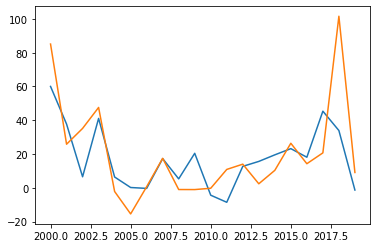

In [96]:
# Lazy way to plot results 
apriori = inv_true.mod.emissions[::12].sum(1)
plt.plot(time, apriori + np.sum(inv_true.mat.x_hat.reshape(-1,4),1))
plt.plot(time, apriori + np.sum(x_hat.reshape(-1,4),1))


array([85.11245022, 73.96430868, 58.36871597, 75.64707414, 58.30056846,
       55.19111988, 54.92660889, 63.74564021, 57.74710188, 65.31423979,
       52.91234514, 50.81684171, 61.45137524, 62.91482369, 64.8582516 ,
       66.69919992, 64.15391999, 77.78775015, 72.05735394, 54.44024906])